# Imports

In [1]:


from _dfguru import DataFrameGuru as DFG
from _occupancy_forecasting import load_data

import torch

import numpy as np
import os
dfg = DFG()
torch.cuda.empty_cache()

import ast
import pandas as pd

import matplotlib.pyplot as plt

import datetime
import json

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio

from _plotting import DataPlotter


# Utility Functions & Classes

In [2]:
class StatsLogger():
    
    def __init__(self):
        self.comb_lists = []
        self.model_losses = []
        self.zero_baselines = []
        self.naive_baselines = []
        self.avg_baselines = []
        self.dataset_types = []
        self.loss_types = []
        
    def return_dataframe(self, run_id):
        dataframe_dict = {
            "run_id": run_id,
            "dataset": self.dataset_types,
            "loss_type": self.loss_types,
            "combinations": self.comb_lists,
            "model_losses": self.model_losses,
        }
        if len(self.zero_baselines) > 0:
            dataframe_dict["zero_baselines"] = self.zero_baselines
        
        if len(self.naive_baselines) > 0:
            dataframe_dict["naive_baselines"] = self.naive_baselines
            
        if len(self.avg_baselines) > 0:
            dataframe_dict["avg_baselines"] = self.avg_baselines
        
        return pd.DataFrame(dataframe_dict)
    
def handle_array_types(array_type, array, dataset, loss_type, logger):
    
    if array_type == "Combinations":
                    
        logger.dataset_types.extend(np.repeat(dataset, len(array)))
        logger.loss_types.extend(np.repeat(loss_type, len(array)))
        
        logger.comb_lists.extend(array)
        
    elif array_type == "Model Losses":
        logger.model_losses.extend(array)
        
    elif array_type == "BL zero Losses":
        logger.zero_baselines.extend(array)
        
    elif array_type == "BL naive Losses":
        logger.naive_baselines.extend(array)

    elif array_type == "BL avg Losses":
        logger.avg_baselines.extend(array)

    else:
        print(array_type, array)
        raise ValueError("array_type not recognized")
    

In [3]:
############ Inputs ############
#args = parse_arguments()
#args = prompt_for_missing_arguments(args)0
#n_run = args.n_run
#n_param = args.n_param

################################

path_to_checkpoints = "/home/berni/transfer_from_server/wrap_up_combs_1"
path_to_data = "data/occupancy_forecasting"
path_to_results = "results_wrapup_normal_combs.txt"
helper_path = os.path.join(path_to_data, "helpers_occpred.json")

frequency = "15min"
split_by = "time"


train_dict, val_dict, test_dict = load_data(
    path_to_data_dir=path_to_data, 
    frequency=frequency, 
    split_by=split_by,
    dfguru=dfg,
    with_examweek=False
)


data = train_dict[0]


In [4]:

with open(helper_path, "r") as f:
    helper = json.load(f)       
norm_registered = helper["columns_to_normalize"]["registered"]
norm_temperature = helper["columns_to_normalize"]["tl"]

In [5]:
from _occupancy_forecasting import ResultsAnalyis

path_to_checkpoints = "/home/berni/transfer_from_server/wrap_up_combs_2"
path_to_data = "data/occupancy_forecasting"
path_to_results = "results_wrapup_normal_combs_2.txt"

analyzer = ResultsAnalyis(
    path_to_data=path_to_data,
)

## Load results

In [6]:
# read txt file with training results

#with open(results_filename, "r") as f:
#    lines = f.readlines()
#    line_str = "".join(lines)
    
    
#list_of_runs = line_str.split("\n\n\n")
## remove empty strings
#list_of_runs = [run for run in list_of_runs if run != ""][:-1]
path_to_data = "data/occupancy_forecasting"

paths_to_checkpoints = [
    "/home/berni/transfer_from_server/wrap_up_combs_1",
    "/home/berni/transfer_from_server/wrap_up_combs_2"
]
paths_to_results = [
    "results_wrapup_normal_combs_1.txt",
    "results_wrapup_normal_combs_2.txt"
]

analyzer = ResultsAnalyis(
    path_to_data=path_to_data,
)

parse_results = analyzer.data_preparation(paths_to_results, paths_to_checkpoints)
pivot_results = analyzer.filter_clean_pivot(parse_results, {"loss_type": "MAE"})

33488
16744
16672


In [8]:
pivot_results.value_counts("run_id")

run_id
4    1709
3    1704
0    1681
1    1680
2    1562
Name: count, dtype: int64

In [7]:
#list_of_dfs = []
#for run in list_of_runs:
    
#    splitted_run = run.split("\n")
#    # filter out empty strings
#    splitted_run = [elem for elem in splitted_run if elem != ""]

#    # correct split such that \n does not happen inside and elements
#    splitted_run_corrected = []
#    for elem in splitted_run[2:]:
        
#        by_bar = elem.split("|")
#        if len(by_bar) == 2:
#            splitted_run_corrected.append(elem)
            
#        elif len(by_bar) == 1:
#            if by_bar[0] == "":
#                continue

#            if len(by_bar[0].split(":")) == 2:
#                splitted_run_corrected.append(elem)
#            else:
#                splitted_run_corrected[-1] = splitted_run_corrected[-1] + elem
                
#        else:
#            raise


#    run_id = int(splitted_run[0].split(" ")[2])
#    #if (run_id < 13) or (run_id > 16):
#    #    continue

#    logger = StatsLogger()
    
#    for elem in splitted_run_corrected:

#        by_bar = elem.split("|")

#        if len(by_bar) == 2:
#            dataset = by_bar[0].split(":")[1].strip()
#            loss_type = by_bar[1].split(":")[1].strip()
 
#        elif len(by_bar) == 1:
            
#            if by_bar[0] == "":
#                continue
            
#            array_type, array = by_bar[0].split(":")
#            array_type = array_type.strip()
            
#            if array_type == "Hyperparameters":
#                continue
            
#            array = array.strip()
#            array = np.array(ast.literal_eval(array))
#            handle_array_types(array_type, array, dataset, loss_type, logger)

#    run_df = logger.return_dataframe(run_id)
    
#    list_of_dfs.append(run_df)
    
#df_results = pd.concat(list_of_dfs).reset_index(drop=True)
#df_results

In [8]:
df_results = analyzer.parse_list_of_runs(list_of_runs)


df_results

,run_id,dataset,loss_type,combinations,model_losses,zero_baselines
0,0,val,MAE,"[0, 112]",0.007574,0.018018
1,0,val,MAE,"[0, 252]",0.007655,0.018018
2,0,val,MAE,"[0, 569]",0.007689,0.018018
3,0,val,MAE,"[0, 412]",0.007734,0.018018
4,0,val,MAE,"[0, 232]",0.007757,0.018018
...,...,...,...,...,...,...
10847,3,test,R2,"[3, 224]",-3.642754,-0.563866
10848,3,test,R2,"[3, 46]",-3.892576,-0.563866
10849,3,test,R2,"[3, 490]",-4.296873,-0.563866
10850,3,test,R2,"[3, 175]",-4.869076,-0.563866


In [9]:
## iterate through all combinations and load hyperparameters
#import json
#for idx, row in df_results.iterrows():
#    comb = row["combinations"]
    
#    comb_path = os.path.join(path_to_checkpoints, f"run_{comb[0]}/comb_{comb[1]}")
    
#    hyperparameters_path = os.path.join(comb_path, "hyperparameters.json")

    
#    hyperparameters = json.load(open(hyperparameters_path, "r"))
    
#    # overwrite combinations with tuple of run_id and comb_id
#    df_results.at[idx, "combinations"] = (row["run_id"], comb[1])
    
#    # add all hyperparameters to the dataframe
#    for key, value in hyperparameters.items():
#        df_results.at[idx, key] = str(value)

#print(len(df_results))

#df_results.head()

In [10]:
df_results_added = analyzer.add_hyperparameters(df_results)
print(len(df_results_added))

df_results_added.head()

10852


,run_id,dataset,loss_type,combinations,model_losses,zero_baselines,info,model_class,device,split_by,...,differencing,layer_norm,weight_decay,forget_gate,include_x_features,zero_sample_drop_rate,x_size,y_features_size,y_size,occcount
0,0,val,MAE,"(0, 112)",0.007574,0.018018,Run 0: exhaustive feature combinations,ed_lstm,cuda:3,time,...,none,False,0,True,True,0.1,4,3,1,False
1,0,val,MAE,"(0, 252)",0.007655,0.018018,Run 0: exhaustive feature combinations,ed_lstm,cuda:3,time,...,none,False,0,True,True,0.1,7,6,1,False
2,0,val,MAE,"(0, 569)",0.007689,0.018018,Run 0: exhaustive feature combinations,ed_lstm,cuda:3,time,...,none,False,0,True,True,0.1,8,7,1,False
3,0,val,MAE,"(0, 412)",0.007734,0.018018,Run 0: exhaustive feature combinations,ed_lstm,cuda:3,time,...,none,False,0,True,True,0.1,5,4,1,False
4,0,val,MAE,"(0, 232)",0.007757,0.018018,Run 0: exhaustive feature combinations,ed_lstm,cuda:3,time,...,none,False,0,True,True,0.1,5,4,1,False


In [11]:

def filter_dataframe_by_column_value(df, column, value):
    return df[df[column] == value].reset_index(drop=True)

def filter_dataframe_by_dict(df, dict_filter):
    for key, value in dict_filter.items():
        df = filter_dataframe_by_column_value(df, key, value)
    return df


df_results_filtered = analyzer.filter_dataframe_by_dict(
    df_results_added,
    {
        "loss_type": "MAE",
        #"dataset": "test"
        #"frequency": "15min",
        #"lr": "0.001",
        #"batch_size": "32",
       # "with_examweek": "False",
        #"course_encoding_dim": "3",
        #"room_ids": "[0]",
        #"num_layers": "3",
        #"hidden_size": "[32, 32]",
        #"y_horizon": "36",
        #"dataset": "test"
    }
)
print(df_results_filtered)

      run_id dataset loss_type combinations  model_losses  zero_baselines  \
0          0     val       MAE     (0, 112)      0.007574        0.018018   
1          0     val       MAE     (0, 252)      0.007655        0.018018   
2          0     val       MAE     (0, 569)      0.007689        0.018018   
3          0     val       MAE     (0, 412)      0.007734        0.018018   
4          0     val       MAE     (0, 232)      0.007757        0.018018   
...      ...     ...       ...          ...           ...             ...   
5421       3    test       MAE     (3, 441)      0.022263        0.026632   
5422       3    test       MAE      (3, 40)      0.022671        0.026632   
5423       3    test       MAE      (3, 31)      0.022727        0.026632   
5424       3    test       MAE      (3, 46)      0.022791        0.026632   
5425       3    test       MAE     (3, 154)      0.022986        0.026632   

                                        info model_class  device split_by  

In [12]:
# keep onyl necessary columns
df_results_cropped = df_results_filtered[["dataset", "features", "run_id", "model_losses"]]


### Try to create table with test and val loss for every combination !

In [13]:
# combine all runs with the same dataset and features
df_losses = df_results_cropped.pivot(index=['features', 'run_id'], columns='dataset', values='model_losses').reset_index()
df_losses.columns = ['features', 'run_id', 'test_loss', 'val_loss']

df_losses


,features,run_id,test_loss,val_loss
0,occrate_avgocc,0,0.018359,0.010644
1,occrate_avgocc,1,0.017980,0.010549
2,occrate_avgocc,2,0.018525,0.010517
3,occrate_avgocc,3,0.018096,0.010642
4,occrate_avgocc_coursenumber,0,0.015517,0.007885
...,...,...,...,...
2708,occrate_weather_type_registered_studyarea,3,0.016846,0.009557
2709,occrate_weather_type_studyarea,0,0.016993,0.009996
2710,occrate_weather_type_studyarea,1,0.016538,0.010032
2711,occrate_weather_type_studyarea,2,0.016425,0.010276


### Suggestion:

In [14]:
df = df_losses.copy(deep=True)
df

,features,run_id,test_loss,val_loss
0,occrate_avgocc,0,0.018359,0.010644
1,occrate_avgocc,1,0.017980,0.010549
2,occrate_avgocc,2,0.018525,0.010517
3,occrate_avgocc,3,0.018096,0.010642
4,occrate_avgocc_coursenumber,0,0.015517,0.007885
...,...,...,...,...
2708,occrate_weather_type_registered_studyarea,3,0.016846,0.009557
2709,occrate_weather_type_studyarea,0,0.016993,0.009996
2710,occrate_weather_type_studyarea,1,0.016538,0.010032
2711,occrate_weather_type_studyarea,2,0.016425,0.010276


In [24]:
analyzer = ResultsAnalyis(
    path_to_checkpoints=path_to_checkpoints,
    path_to_resultsfile=path_to_results,
    path_to_data=path_to_data,
)

parse_results = analyzer.data_preparation()
pivot_results = analyzer.filter_clean_pivot(parse_results, {"loss_type": "MAE"})
pivot_results.value_counts("run_id")

       run_id dataset loss_type combinations  model_losses  zero_baselines  \
0           0     val       MAE     (0, 112)      0.007574        0.018018   
1           0     val       MAE     (0, 252)      0.007655        0.018018   
2           0     val       MAE     (0, 569)      0.007689        0.018018   
3           0     val       MAE     (0, 412)      0.007734        0.018018   
4           0     val       MAE     (0, 232)      0.007757        0.018018   
...       ...     ...       ...          ...           ...             ...   
17059       4    test        R2     (4, 879)     -3.169058       -0.563866   
17060       4    test        R2     (4, 539)     -3.173368       -0.563866   
17061       4    test        R2     (4, 416)     -3.221320       -0.563866   
17062       4    test        R2     (4, 881)     -3.544618       -0.563866   
17063       4    test        R2     (4, 203)     -4.647846       -0.563866   

                                         info model_class  devi

,features,run_id,test_loss,val_loss
0,occrate_avgocc,0,0.018359,0.010644
1,occrate_avgocc,1,0.017980,0.010549
2,occrate_avgocc,2,0.018525,0.010517
3,occrate_avgocc,3,0.018096,0.010642
4,occrate_avgocc,4,0.018360,0.010531
...,...,...,...,...
4261,occrate_weather_type_studyarea,0,0.016993,0.009996
4262,occrate_weather_type_studyarea,1,0.016538,0.010032
4263,occrate_weather_type_studyarea,2,0.016425,0.010276
4264,occrate_weather_type_studyarea,3,0.016699,0.009606


In [26]:
pivot_results.value_counts("run_id")

run_id
3    886
4    885
0    874
1    868
2    753
Name: count, dtype: int64

In [22]:
analyzer.group_by_features(pivot_results)

analyzer.group_by_subfeatures(pivot_results)

analyzer.group_by_fundamental_features(pivot_results)

,index,mean_validation_mae,std_validation_mae,mean_test_mae,std_test_mae
0,avgocc,0.008906,0.000877,0.016994,0.001022
1,coursenumber,0.008526,0.000386,0.016585,0.000880
2,dow,0.009112,0.001383,0.017188,0.001257
3,exam,0.009191,0.001568,0.017773,0.001209
4,hod,0.009340,0.001589,0.017064,0.001314
5,occrate,0.009137,0.001381,0.017100,0.001253
6,registered,0.008685,0.000461,0.016831,0.000954
7,studyarea,0.008951,0.000469,0.016733,0.000733
8,tutorium_test_cancelled,0.009231,0.001600,0.017086,0.001499
9,type,0.008914,0.000451,0.016778,0.000992


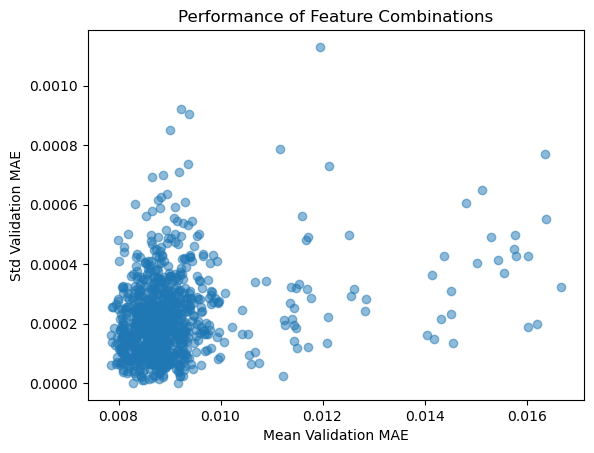

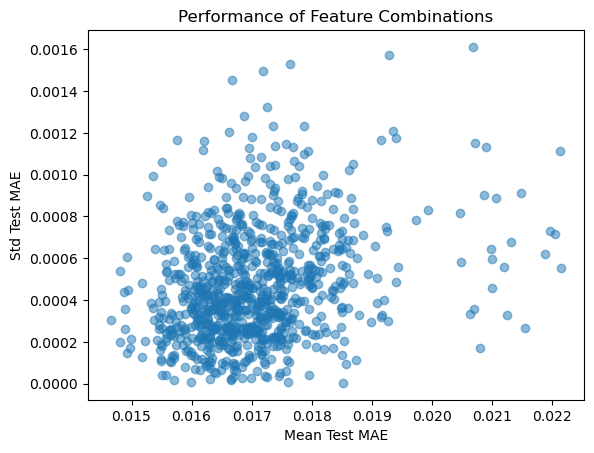

In [203]:
# That one works but consider interactive version

raise NotImplementedError("Interactive version")
# implement an interactive plot with plotly


# scatter plot of mean and std of validation MAE
plt.scatter(df_grouped_by_features['mean_validation_mae'], df_grouped_by_features['std_validation_mae'], alpha=0.5)
plt.xlabel('Mean Validation MAE')
plt.ylabel('Std Validation MAE')
plt.title('Performance of Feature Combinations')
plt.show()

plt.scatter(df_grouped_by_features['mean_test_mae'], df_grouped_by_features['std_test_mae'], alpha=0.5)
plt.xlabel('Mean Test MAE')
plt.ylabel('Std Test MAE')
plt.title('Performance of Feature Combinations')
plt.show()

In [159]:
# not really applicable for that many combinations

#import seaborn as sns

## Convert feature analysis to a DataFrame if not already
#heatmap_data = df_features_and_combs[['mean_validation_mae', 'mean_test_mae']]
#sns.heatmap(heatmap_data, annot=True, fmt=".4f", cmap="coolwarm")
#plt.title("Performance of Individual Features")
#plt.show()


In [160]:
#from pandas.plotting import parallel_coordinates

## not really applicable for that many combinations

#top_combinations = df_grouped.nsmallest(100, 'mean_test_mae')  # Top 100 combinations
#parallel_data = top_combinations.melt(id_vars='features', value_vars=['mean_validation_mae', 'std_validation_mae', 'mean_test_mae', 'std_test_mae'])

## Pivot the melted data back to wide format
#wide_data = parallel_data.pivot(index='features', columns='variable', values='value').reset_index()

## Plot parallel coordinates
#parallel_coordinates(wide_data, 'features', color=['blue', 'green', 'red', 'purple'])
#plt.title("Parallel Coordinates Plot for Feature Combinations")
#plt.show()

In [161]:
# not really applicable for that many combinations

#df_features_and_combs[['mean_validation_mae', 'mean_test_mae']].plot.bar(
#    yerr=df_features_and_combs[['std_validation_mae', 'std_test_mae']].values.T,
#    figsize=(10, 6),
#    capsize=4,
#    title="Mean and Std of MAE for Individual Features"
#)
#plt.show()


In [204]:
# incorportate fundamental features
def get_binary_features(dataframe):
    fundamental_features = ["occrate", "exam", "tutorium_test_cancelled", "registered", "type", 
                        "studyarea", "coursenumber", "dow", "hod", "weather", "avgocc"]

    binary_features = pd.DataFrame()
    for feature in fundamental_features:
        binary_features[feature] = dataframe['features'].apply(lambda x: 1 if feature in x else 0)
    
    return binary_features

## Split the strings into lists of fundamental features
#fundamental_features = ["occrate", "exam", "tutorium_test_cancelled", "registered", "type", 
#                    "studyarea", "coursenumber", "dow", "hod", "weather", "avgocc"]
## Function to split strings into fundamental features
#def extract_fundamental_features(feature_string, fundamental_features):
#    # Split the string by underscore and filter for fundamental features
#    return [f for f in fundamental_features if f in feature_string]
#df["fundamental_features"] = df["features"].apply(lambda x: extract_fundamental_features(x, fundamental_features))
#print(df['fundamental_features'])

In [205]:
# return counts of individual features
binary_features = get_binary_features(df_grouped_by_features)
binary_features.sum().sort_values(ascending=False)

occrate                    886
avgocc                     386
coursenumber               375
dow                        316
exam                       316
weather                    316
tutorium_test_cancelled    310
hod                        310
type                       309
registered                 308
studyarea                  307
dtype: int64

In [206]:


# Step 1: Aggregate df by features to match feature_analysis_df
aggregated_df = df.groupby('features')[['test_loss', 'val_loss']].mean().reset_index()

# Step 2: Ensure binary_features matches feature_analysis_df
binary_features = get_binary_features(df)
binary_features = binary_features.groupby(df['features']).first().sort_index()  # One row per feature combination

# Step 3: Align binary_features with feature_analysis_df
binary_features = binary_features.loc[df_grouped_by_subfeatures.index]  # Ensure same order as feature_analysis_df

# Step 4: Compute correlations
target_metrics = df_grouped_by_subfeatures["mean_test_mae"]
correlations = binary_features.corrwith(target_metrics)

print(correlations)
## Step 5: Visualize the results
#import matplotlib.pyplot as plt

#correlations.sort_values(ascending=True).plot.barh(figsize=(10, 6))
#plt.title("Correlation of Feature Inclusion with Mean MAE")
#plt.xlabel("Correlation")
#plt.show()


#correlations.sort_values(ascending=True).plot.barh(figsize=(10, 6))
#plt.title("Correlation of Feature Inclusion with Mean MAE")
#plt.xlabel("Correlation")
#plt.show()

occrate                         NaN
exam                       0.534811
tutorium_test_cancelled   -0.090175
registered                -0.105917
type                      -0.151076
studyarea                 -0.164643
coursenumber              -0.352316
dow                        0.041307
hod                       -0.051596
weather                    0.371722
avgocc                     0.010976
dtype: float64


### Explanation of Correlation

Why `occrate` is NaN

====================

- The `occrate` column in `binary_features` is constant (all 1s):

  occrate

  1

  1

  1

  1



- A constant feature has zero variance (σ_X = 0).

- In Pearson's correlation formula:

  r = Cov(X, Y) / (σ_X ⋅ σ_Y)

  The denominator (σ_X) becomes zero, and the correlation cannot be computed, resulting in `NaN`.



Calculation for `avgocc`

=========================

We calculate the correlation for `avgocc` as an example.



Values:

-------

- X = [0, 1, 1, 0] (from `binary_features['avgocc']`)

- Y = [0.012485, 0.012285, 0.013611, 0.014393] (from `target_metrics`)



Step 1: Compute Means

---------------------

X̄ = (0 + 1 + 1 + 0) / 4 = 0.5

Ȳ = (0.012485 + 0.012285 + 0.013611 + 0.014393) / 4 = 0.013194



Step 2: Compute Deviations

--------------------------

X_i - X̄ = [-0.5, 0.5, 0.5, -0.5]

Y_i - Ȳ = [0.012485 - 0.013194, 0.012285 - 0.013194, 0.013611 - 0.013194, 0.014393 - 0.013194]

        = [-0.000709, -0.000909, 0.000417, 0.001199]



Step 3: Compute Covariance

--------------------------

Cov(X, Y) = Σ (X_i - X̄)(Y_i - Ȳ)

          = (-0.5)(-0.000709) + (0.5)(-0.000909) + (0.5)(0.000417) + (-0.5)(0.001199)

          = 0.000354 - 0.000455 + 0.000208 - 0.000599 = -0.000492



Step 4: Compute Variances

-------------------------

σ_X² = Σ (X_i - X̄)² = (-0.5)² + (0.5)² + (0.5)² + (-0.5)² = 1.0

σ_Y² = Σ (Y_i - Ȳ)²

      = (-0.000709)² + (-0.000909)² + (0.000417)² + (0.001199)²

      = 0.000000503 + 0.000000826 + 0.000000174 + 0.000001438 = 0.000002941



σ_X = √1.0 = 1.0

σ_Y = √0.000002941 = 0.001715



Step 5: Compute Correlation

---------------------------

r = Cov(X, Y) / (σ_X ⋅ σ_Y)

r = -0.000492 / (1.0 ⋅ 0.001715) = -0.286


# Impact of one Feature

Measuring the impact of a single feature, even when it appears in combination with others, can be approached by isolating its contribution to the model's performance. Here’s a systematic way to assess the impact of individual features:

Approach 1: Marginal Contribution (Shapley Value Inspired)

    Baseline Performance: Compute the average performance (e.g., mean validation MAE) for all combinations without the feature.
    With Feature Performance: Compute the average performance for all combinations with the feature.
    Impact: Measure the difference in average performance:
    Impact=Mean(MAE without feature)−Mean(MAE with feature)
    Impact=Mean(MAE without feature)−Mean(MAE with feature)
        A positive impact indicates the feature improves performance.
        A negative impact indicates the feature worsens performance.

In [164]:
list(correlations.index)

['occrate',
 'exam',
 'tutorium_test_cancelled',
 'registered',
 'type',
 'studyarea',
 'coursenumber',
 'dow',
 'hod',
 'weather',
 'avgocc']

In [208]:
def calc_marginal_contribution(dataframe, feature, target):
    with_feature = dataframe[dataframe['features'].str.contains(feature)]
    without_feature = dataframe[~dataframe['features'].str.contains(feature)]
    return with_feature[target].mean() - without_feature[target].mean()
    
    
target = "mean_test_mae" 
#for feature in all_features:
for feature in list(correlations.index):
    impact = calc_marginal_contribution(df_grouped_by_features, feature, "mean_test_mae")
    print(f"Impact of {feature}: {impact:.4f}")
    
#feature = "coursenumber"
#target = "mean_test_mae"
#impact = calc_marginal_contribution(df_grouped_by_features, feature, target)
#print(f"Impact of {feature}: {impact:.4f}")


Impact of occrate: nan
Impact of exam: 0.0010
Impact of tutorium_test_cancelled: -0.0001
Impact of registered: -0.0004
Impact of type: -0.0004
Impact of studyarea: -0.0005
Impact of coursenumber: -0.0008
Impact of dow: 0.0001
Impact of hod: -0.0001
Impact of weather: 0.0006
Impact of avgocc: -0.0001


Approach 2: Statistical Comparison

## Check statistics slides!! must it be standard normal?

# We need larger smaple check servers!!

Perform a statistical test to compare the performance of combinations with and without the feature:

    Null Hypothesis: The feature does not improve performance (mean performance is the same with or without it).
    Use a t-test or Mann-Whitney U test to compare performance distributions.

In [210]:
from scipy.stats import ttest_ind

dataframe = df_grouped_by_features
feature = "exam"
target = "mean_test_mae"

with_feature = dataframe[dataframe['features'].str.contains(feature)]
without_feature = dataframe[~dataframe['features'].str.contains(feature)]

# Extract performance distributions
with_performance = with_feature[target]
without_performance = without_feature[target]

# Perform t-test
#print(df_grouped_by_features)
t_stat, p_value = ttest_ind(with_performance, without_performance, equal_var=False)
print(f"T-statistic: {t_stat:.4f}, P-value: {p_value:.4f}")


T-statistic: 13.8947, P-value: 0.0000


In [212]:
# Try mann-whitney u test
from scipy.stats import mannwhitneyu

dataframe = df_grouped_by_features
feature = "exam"
target = "mean_test_mae"

# Separate groups by "coursenumber"
with_feature = dataframe[dataframe['features'].str.contains(feature)]
without_feature = dataframe[~dataframe['features'].str.contains(feature)]

group_true = with_feature[target]
group_false = without_feature[target]

# Perform Mann-Whitney U test
stat, p_value = mannwhitneyu(group_true, group_false, alternative='two-sided')
print(f"Mann-Whitney U Test: U-statistic = {stat}, P-value = {p_value}")


Mann-Whitney U Test: U-statistic = 145219.0, P-value = 1.2546447718355101e-51


Approach 3: Feature Inclusion Analysis

Analyze how the inclusion of a feature affects performance within combinations:

    Group by feature combinations.
    Compare the mean performance for combinations with and without the feature controlling for other features.

In [224]:
# Create a binary column for feature inclusion
def calc_feature_inclusion_effect(dataframe, feature, target):
    dataframe[feature] = dataframe['features'].apply(lambda x: feature in x)
    feature_inclusion = dataframe.groupby(feature)[target].agg(['mean', 'std']).reset_index()
    return feature_inclusion


dataframe = df_grouped_by_subfeatures.reset_index().rename(columns={"index": "features"})
feature = "tutorium_test_cancelled"
target = "mean_test_mae"
feature_inclusion = calc_feature_inclusion_effect(dataframe, feature, target)
print(feature_inclusion)


   tutorium_test_cancelled      mean       std
0                    False  0.016946  0.000710
1                     True  0.016783  0.001088


Approach 4: Interaction Effects

Model interaction effects using a simple regression model:

    Encode feature combinations as binary variables (one-hot encoding for presence/absence of each feature).
    Fit a linear regression where the dependent variable is the mean_validation_mae, and independent variables are binary indicators for each feature.
    Coefficients of the regression indicate the individual contribution of each feature, controlling for others.

In [225]:
from sklearn.linear_model import LinearRegression

def calc_regression_feature_impact(dataframe, target, intercept):
    
    binary_features = get_binary_features(dataframe)
    X = binary_features
    y = dataframe[target]
    
    if intercept:
        model = LinearRegression().fit(X, y)

        reg_results = pd.Series(np.append(model.coef_, model.intercept_), index=list(X.columns) + ['intercept'])
    else:
        model = LinearRegression(fit_intercept=False).fit(X, y)
        reg_results = pd.Series(model.coef_, index=X.columns)
    
    return reg_results, model
    

In [229]:

reg_results, model = calc_regression_feature_impact(df, 'test_loss', intercept=True)
print(reg_results.sort_values(ascending=True))



coursenumber              -0.000881
studyarea                 -0.000583
type                      -0.000515
registered                -0.000444
avgocc                    -0.000254
hod                       -0.000107
tutorium_test_cancelled   -0.000084
occrate                    0.000000
dow                        0.000095
weather                    0.000589
exam                       0.000942
intercept                  0.017561
dtype: float64


Approach 5: SHAP Values (Model-Agnostic Explanation)

Train a surrogate model (e.g., decision tree or random forest) on the feature-performance data and use SHAP (SHapley Additive exPlanations) to measure each feature's contribution to the performance metric.

Steps:

    Train a surrogate model to predict mean_validation_mae based on feature combinations.
    Use SHAP to decompose predictions into feature contributions.

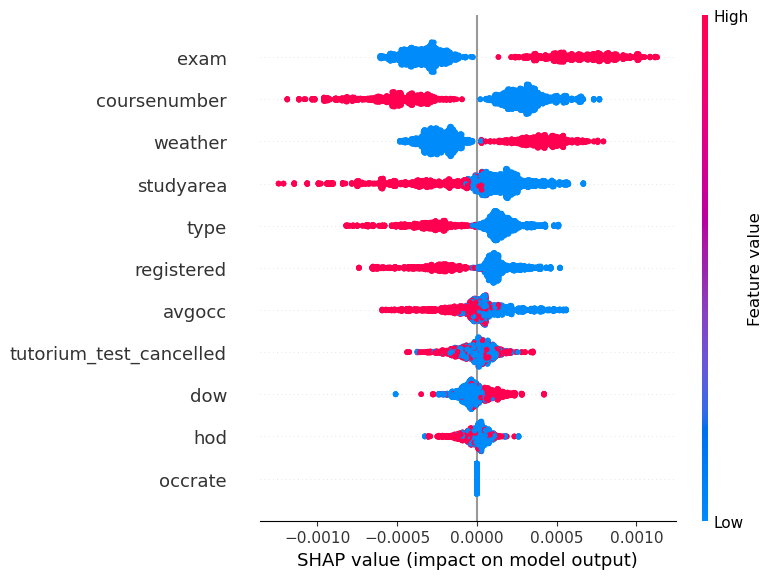

In [231]:
# Create DataFrame

#def calc_regression_feature_impact(dataframe, target):
    
#    binary_features = get_binary_features(dataframe)
#    X = binary_features
#    y = dataframe[target]
    
#    model = LinearRegression().fit(X, y)

#    reg_results = pd.Series(np.append(model.coef_, model.intercept_), index=list(X.columns) + ['intercept'])
    
#    return reg_results, model

import shap
from sklearn.tree import DecisionTreeRegressor


dataframe = df
X = get_binary_features(dataframe)
y = dataframe["test_loss"]


# Fit a Decision Tree Regressor
model = DecisionTreeRegressor(random_state=42)
model.fit(X, y)

# Initialize SHAP TreeExplainer
explainer = shap.TreeExplainer(model)

shap_set = X
shap_values = explainer(shap_set)

# Summary plot for SHAP values
shap.summary_plot(shap_values, shap_set)

# Kinda old!

In [18]:
# fill dataframe with group means and stds



group_list = []

for group, df in results_out.groupby(["features"]):
    print(group)
    print(df["model_losses"].mean())
    print(df["model_losses"].std())
    print()
    # add data to new dataframe
    
    group_list.append(
        (group[0], df["model_losses"].mean(), df["model_losses"].std())
    )
    
df_plot = pd.DataFrame(group_list, columns=["features", "mean", "std"])



('occrate',)
0.020438333333333336
0.0002250896117845821

('occrate_avgocc',)
0.018653666666666666
0.0003666365139117126

('occrate_avgocc_coursenumber',)
0.016270666666666666
0.00020652441340755182

('occrate_coursenumber',)
0.016612666666666668
0.0004147051161166604



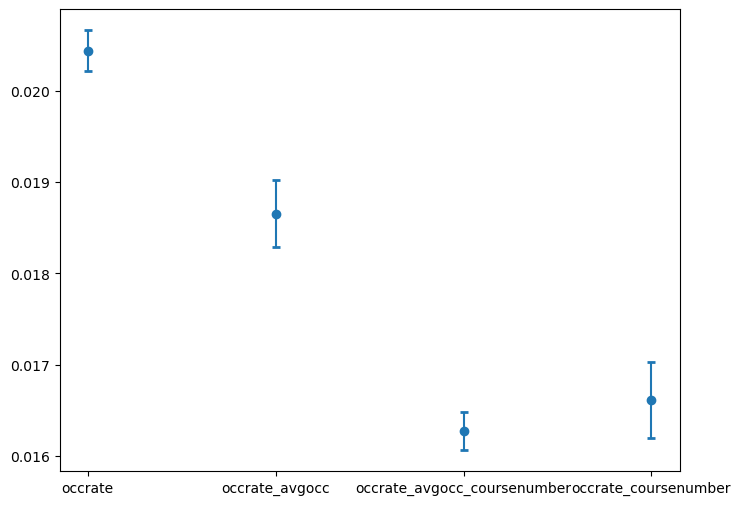

In [19]:
import matplotlib.pyplot as plt

# Plot the results
fig, ax = plt.subplots(figsize=(8, 6))

# Plot mean with error bars (standard deviation)
ax.errorbar(
    df_plot["features"],
    df_plot["mean"],
    yerr=df_plot["std"],
    fmt="o",
    capsize=3,
    capthick=2,
    label="Mean MAE with Std Dev",
)

plt.show()

In [58]:
def advanced_grouping_function(features):
    if "coursenumber" in features:
        return "yes"
    else:
        return "no"
    
    

In [63]:
def advanced_grouping_function(features):
    if "coursenumber" in features:
        return "yes"
    else:
        return "no"
group_by_avgocc = results_out.groupby(results_out["features"].apply(advanced_grouping_function))
group_by_avgocc["model_losses"].mean()


features
no     0.019546
yes    0.016442
Name: model_losses, dtype: float64

In [64]:
def advanced_grouping_function(features):
    if "avgocc" in features:
        return "yes"
    else:
        return "no"
    
group_by_avgocc = results_out.groupby(results_out["features"].apply(advanced_grouping_function))
group_by_avgocc["model_losses"].mean()

features
no     0.018526
yes    0.017462
Name: model_losses, dtype: float64

In [ ]:
pretty_results = results_out[["features", "model_losses", "avg_baselines", "naive_baselines", "zero_baselines"]]

# split features by "_"
pretty_results["features"] = pretty_results["features"].apply(lambda x: x.split("_"))

# do not cut off columns
pd.set_option('display.max_colwidth', None)
pretty_results.reset_index(drop=True, inplace=True)



In [ ]:
#pretty_results.to_csv("pretty_results.csv", index=False)